# Test 1

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args["dry_run"]:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    args = {
        "batch_size": 64,
        "test_batch_size": 1000,
        "epochs": 3,
        "lr": 1.0,
        "gamma": 0.7,
        "no_cuda": False,
        "no_mps": False,
        "dry_run": False,
        "seed": 1,
        "log_interval": 10,
        "save_model": True,
    }

    use_cuda = not args["no_cuda"] and torch.cuda.is_available()
    use_mps = not args["no_mps"] and torch.backends.mps.is_available()

    torch.manual_seed(args["seed"])

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args["batch_size"]}
    test_kwargs = {'batch_size': args["test_batch_size"]}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args["lr"])

    scheduler = StepLR(optimizer, step_size=1, gamma=args["gamma"])
    for epoch in range(1, args["epochs"] + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args["save_model"]:
        torch.save(model.state_dict(), "mnist_cnn.pt")

In [ ]:
main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305400
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.359780
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.830670
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.605961
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.345934
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.446331
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.306768
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.279325
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.555025
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.208878
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.279527
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.327207
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.204888
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.220855
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.273643
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.097318
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.248318
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.112893
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.439383
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.244582
Train Epoch: 1 [12800/60000 (

In [ ]:
model = Net()
model.load_state_dict(torch.load('mnist_cnn.pt'))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset = datasets.MNIST('../data', train=False, transform=transform,
                            download=True)


# for data, target in test_loader:
#     data, target = data.to(device), target.to(device)
#     output = model(data)
#     pred = output.argmax(dim=1, keepdim=True)

In [ ]:
import random

import matplotlib.pyplot as plt

examples = random.sample(list(zip(dataset.data, dataset.targets)), 3)

for data, label in examples:
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True).item()
    plt.imshow(data)
    plt.title(f'true: {label.item()} -- pred: {pred}')
    plt.show()

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

# Test 2

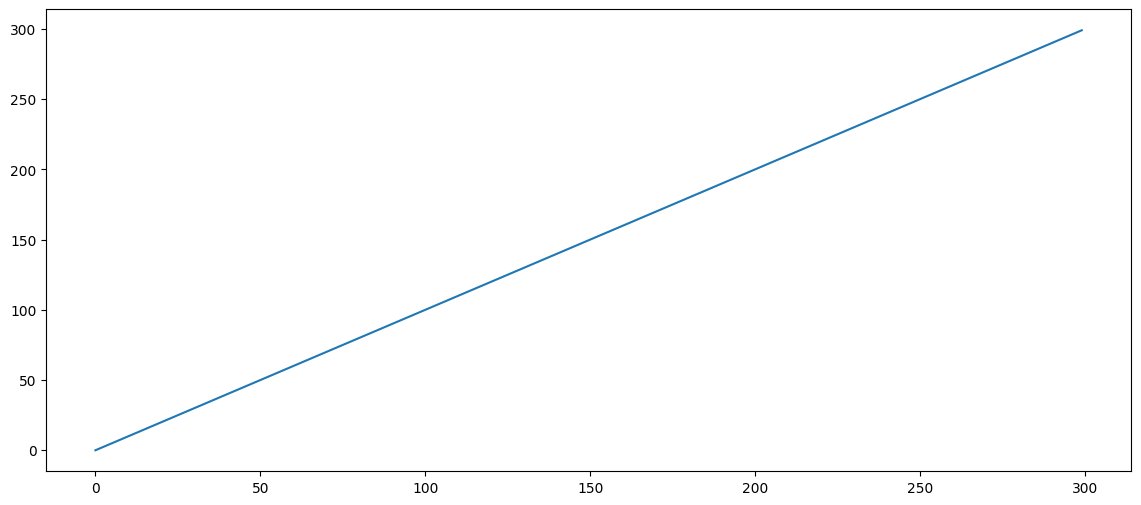

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

size = 300

X = np.array(np.arange(size)).reshape(-1, 1)
y = X.reshape(-1, 1)  # X + (size/2) * np.sin(X / 3)

X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.1)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(X, y)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output = x
        output = self.fc1(output)
        # output = F.relu(output)
        # output = self.fc2(output)
        return output


def train(model, X, y, optimizer, criterion, log_interval):
    model.train()
    for batch_id, (data, target) in enumerate(zip(X, y), start=1):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_id % log_interval == 0:
            print(f'batch {batch_id} -- train loss = {loss.item()}')


def test(model, X, y, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in zip(X, y):
            pred = model(data)
            test_loss += criterion(pred, target).item()

    test_loss /= X.shape[0]
    print(f'                 --  test loss = {test_loss}')

                 --  test loss = 1847.4380466072648
                 --  test loss = 1590.8143734013593
                 --  test loss = 1501.0800485787568
                 --  test loss = 1474.035611149117
                 --  test loss = 1465.2578744888306
                 --  test loss = 1460.9112792544895
                 --  test loss = 1457.681798058969
                 --  test loss = 1454.7784380736175
                 --  test loss = 1451.9846635182698
                 --  test loss = 1446.4985558191936
                 --  test loss = 1443.7756842719184
                 --  test loss = 1441.0614193527788
                 --  test loss = 1438.3553015391033
                 --  test loss = 1435.657687081231
                 --  test loss = 1432.968834347195
                 --  test loss = 1430.2890459979021
                 --  test loss = 1427.618718987924
                 --  test loss = 1424.9579412389685
                 --  test loss = 1419.6658266703287
                 

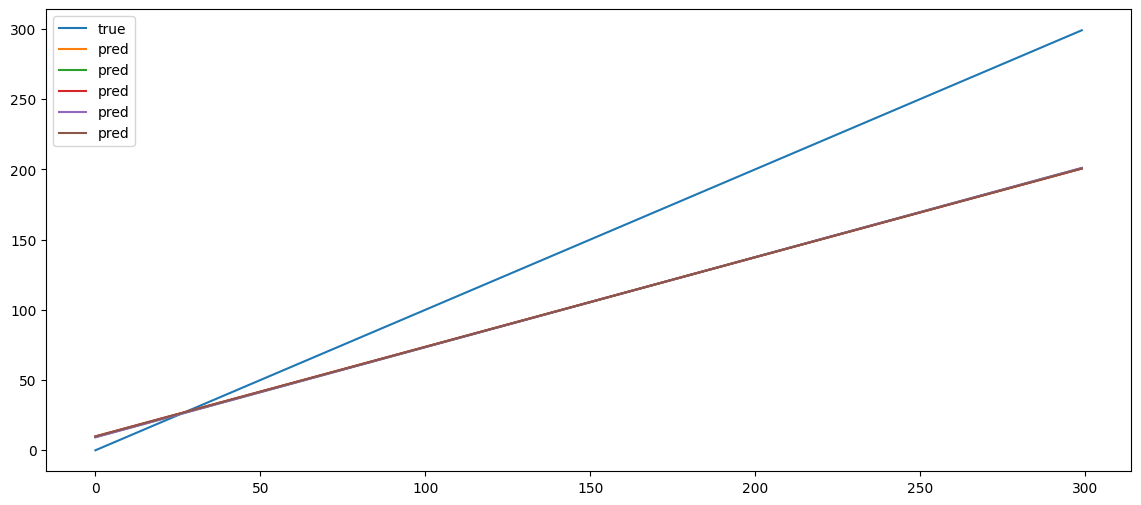

In [ ]:
args = {
    "hidden_size": 5,
    "batch_size": 64,
    "test_batch_size": 1000,
    "epochs": 30,
    "lr": 10.0,
    "gamma": 0.7,
    "seed": 1,
    "log_interval": 100,
    "log_interval_test": 10,
}

torch.manual_seed(1)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

X_train, y_train, X_test, y_test = (torch.Tensor(arr).to(device) for arr in [X_train, y_train, X_test, y_test])

model = Net(args["hidden_size"]).to(device)

optimizer = optim.Adadelta(model.parameters(), lr=args["lr"])
criterion = nn.MSELoss()

for epoch in range(args["epochs"]):
    train(model, X_train, y_train, optimizer, criterion, args["log_interval"])
    if epoch % args['log_interval_test']:
        test(model, X_test, y_test, criterion)


X_tensor, y_tensor = [torch.from_numpy(obj).float().to(device) for obj in [X, y]]

with torch.no_grad():
    model.eval()
    y_pred = model(X_tensor)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(X_tensor, y_tensor, label='true')
ax.plot(X_tensor, y_pred, label='pred')
ax.legend()
plt.show()

In [ ]:


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args["dry_run"]:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


# Training settings

    # train_kwargs = {'batch_size': args["batch_size"]}
    # test_kwargs = {'batch_size': args["test_batch_size"]}

    # if use_cuda:
    #     cuda_kwargs = {'num_workers': 1,
    #                    'pin_memory': True,
    #                    'shuffle': True}
    #     train_kwargs.update(cuda_kwargs)
    #     test_kwargs.update(cuda_kwargs)

    # train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    # test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args["lr"])

scheduler = StepLR(optimizer, step_size=1, gamma=args["gamma"])
for epoch in range(1, args["epochs"] + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

In [ ]:


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args["dry_run"]:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    args = {
        "batch_size": 64,
        "test_batch_size": 1000,
        "epochs": 3,
        "lr": 1.0,
        "gamma": 0.7,
        "no_cuda": False,
        "no_mps": False,
        "dry_run": False,
        "seed": 1,
        "log_interval": 10,
        "save_model": True,
    }

    use_cuda = not args["no_cuda"] and torch.cuda.is_available()
    use_mps = not args["no_mps"] and torch.backends.mps.is_available()

    torch.manual_seed(args["seed"])

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args["batch_size"]}
    test_kwargs = {'batch_size': args["test_batch_size"]}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args["lr"])

    scheduler = StepLR(optimizer, step_size=1, gamma=args["gamma"])
    for epoch in range(1, args["epochs"] + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args["save_model"]:
        torch.save(model.state_dict(), "mnist_cnn.pt")

# Test 3



----------
shape: torch.Size([1000, 1])
first values: tensor([[-1.7295],
        [-1.7260],
        [-1.7225]])
----------
shape: torch.Size([1000, 1])
first values: tensor([[-1.1485],
        [-1.0888],
        [-1.0292]])


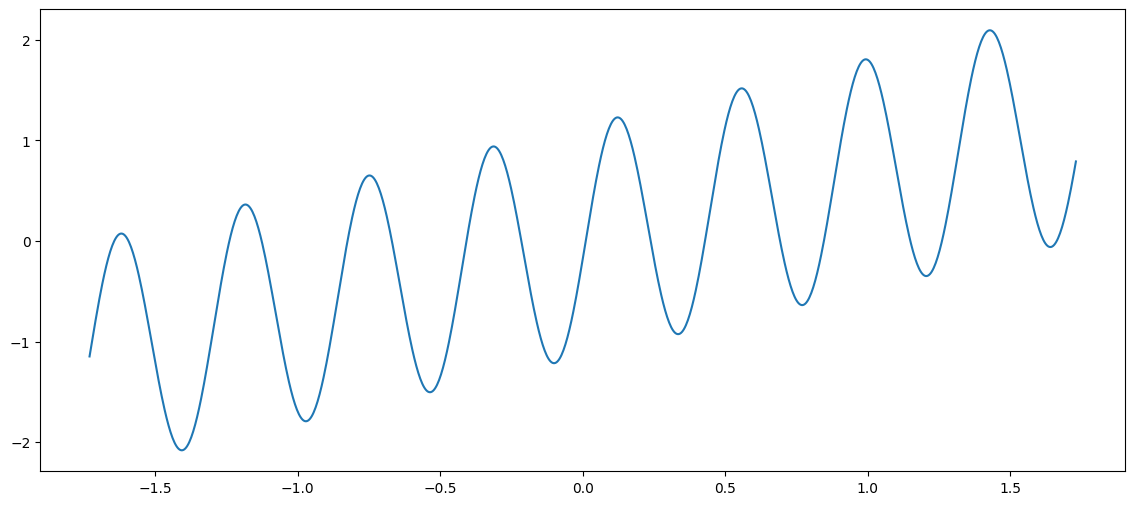

In [43]:
import numpy as np
import torch

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


def info(*tensors, premsg=None, grad=False):
    print('\n')
    if premsg is not None:
        print('###', premsg)
    for tensor in tensors:
        print('-' * 10)
        print('shape:', tensor.shape)
        print('first values:', tensor[:3])
        if grad:
            print('grad:', tensor.grad[:3])


def standardize(tensor):
    return (tensor - tensor.mean()) / tensor.std()


size = 1000

amp = size // 2

X = np.array(np.arange(size), dtype='float64').reshape(-1, 1)
y = (X + amp * np.sin(X * 50 / size)).reshape(-1, 1)  # (X - size//2)**2

# X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.1)


data_dtype = torch.float32

X = torch.tensor(X, dtype=data_dtype)
y = torch.tensor(y, dtype=data_dtype)

X = standardize(X)
y = standardize(y)

info(X, y)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(X, y)
plt.show()

5000 0.6286485195159912
10000 0.5838837027549744
15000 0.5476816892623901
20000 0.4947091341018677
25000 0.4330829381942749
30000 0.37197744846343994
35000 0.3190461993217468
40000 0.2760440409183502
45000 0.23757882416248322
50000 0.20998775959014893


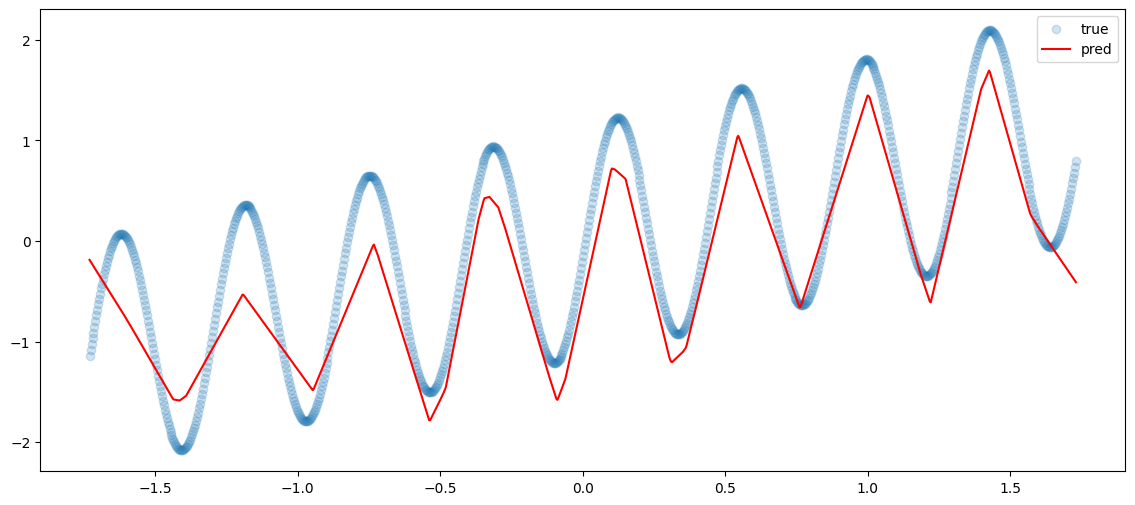

In [49]:
import torch
import math

from more_itertools import flatten


class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        hidden_layers = (
            (torch.nn.Linear(n_hidden_units, n_hidden_units),
             torch.nn.LeakyReLU())
            for _ in range(n_hidden_layers)
        )
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1, n_hidden_units),
            torch.nn.LeakyReLU(),
            *flatten(hidden_layers),
            torch.nn.Linear(n_hidden_units, 1)
        )

    def forward(self, x):
        return self.layers(x)


# Create Tensors to hold input and outputs.
# x = torch.linspace(-math.pi, math.pi, 2000).reshape(-1, 1)
# y = torch.sin(x).reshape(-1, 1)

x = X
y = y

n_hidden_layers = 1
n_hidden_units = 50
n_epochs = 50000
n_log_interval = n_epochs // 10
lr = 1e-2

# Construct our model by instantiating the class defined above
model = MyModel()

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined
# with torch.nn.Parameter) which are members of the model.
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
for t in range(1, n_epochs+1):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % n_log_interval == 0:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

with torch.no_grad():
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.scatter(x, y, label='true', alpha=0.2)
    ax.plot(x, model(x), label='pred', color='red')
    ax.legend()
    plt.show()

5000 0.18354293704032898
10000 0.16453641653060913
15000 0.14824795722961426
20000 0.12369890511035919
25000 0.10971678793430328
30000 0.09786289930343628
35000 0.08450663089752197
40000 0.07566332817077637
45000 0.06578546017408371
50000 0.055928051471710205


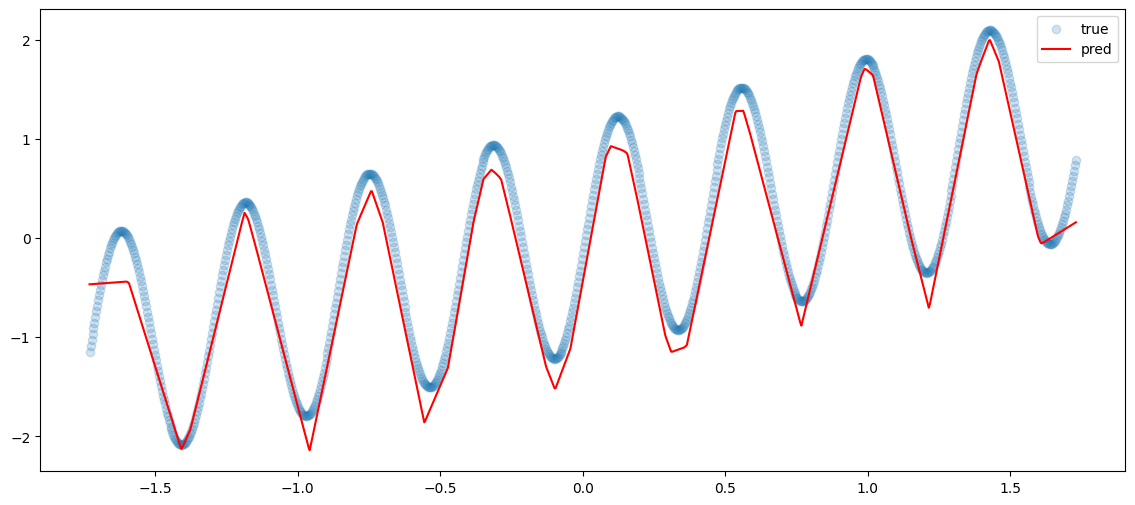

In [50]:
def train(model):
    for t in range(1, n_epochs+1):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x)

        # Compute and print loss
        loss = criterion(y_pred, y)
        if t % n_log_interval == 0:
            print(t, loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model


def plot(model):
    with torch.no_grad():
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.scatter(x, y, label='true', alpha=0.2)
        ax.plot(x, model(x), label='pred', color='red')
        ax.legend()
        plt.show()

model = train(model)
plot(model)

In [17]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(1, 5),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(5, 1)
)
model(x.reshape((-1, 1))[:2])

tensor([[0.4397],
        [0.4390]], grad_fn=<AddmmBackward0>)

=== epoch 0 ===
w1 = 0.661, b1 = 0.661,
w2 = 0.062, b2 = 0.062,
w3 = -0.451, b3 = -0.451,loss = 1.170
=== epoch 200 ===
w1 = 0.662, b1 = 0.662,
w2 = 0.063, b2 = 0.063,
w3 = -0.382, b3 = -0.382,loss = 1.053
=== epoch 400 ===
w1 = 0.663, b1 = 0.663,
w2 = 0.067, b2 = 0.067,
w3 = -0.344, b3 = -0.344,loss = 1.014
=== epoch 600 ===
w1 = 0.664, b1 = 0.664,
w2 = 0.072, b2 = 0.072,
w3 = -0.323, b3 = -0.323,loss = 1.001
=== epoch 800 ===
w1 = 0.665, b1 = 0.665,
w2 = 0.078, b2 = 0.078,
w3 = -0.311, b3 = -0.311,loss = 0.997
=== epoch 1000 ===
w1 = 0.666, b1 = 0.666,
w2 = 0.084, b2 = 0.084,
w3 = -0.305, b3 = -0.305,loss = 0.995
=== epoch 1200 ===
w1 = 0.667, b1 = 0.667,
w2 = 0.090, b2 = 0.090,
w3 = -0.301, b3 = -0.301,loss = 0.994
=== epoch 1400 ===
w1 = 0.667, b1 = 0.667,
w2 = 0.096, b2 = 0.096,
w3 = -0.300, b3 = -0.300,loss = 0.994
=== epoch 1600 ===
w1 = 0.668, b1 = 0.668,
w2 = 0.103, b2 = 0.103,
w3 = -0.300, b3 = -0.300,loss = 0.994
=== epoch 1800 ===
w1 = 0.669, b1 = 0.669,
w2 = 0.110, b2 = 0.

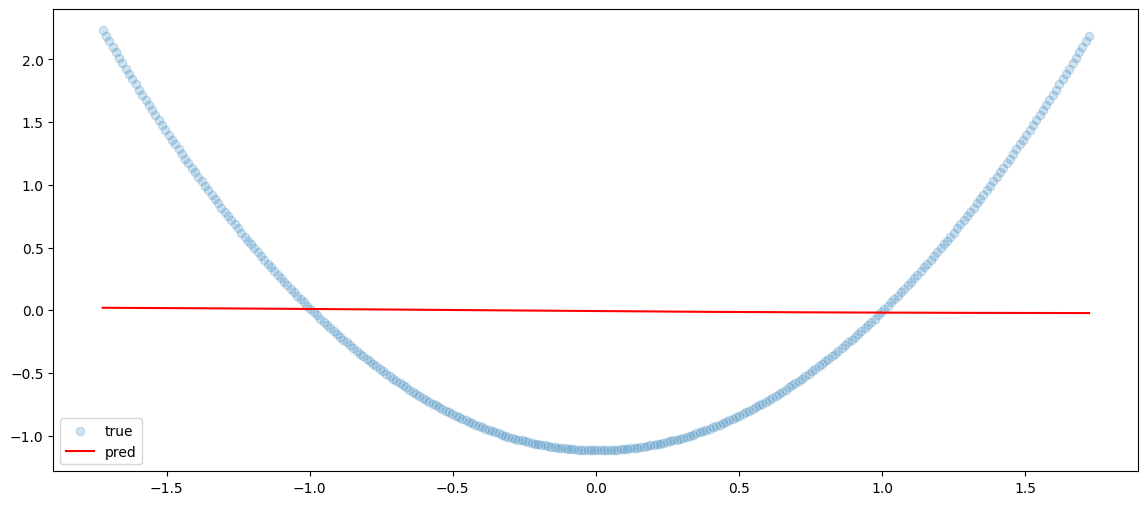

In [72]:
def criterion(y_pred, y):
    return ((y_pred - y)**2).mean()

def forward(x, layers, activation):
    out = x
    for w, b in layers[:-1]:
        out = torch.matmul(out, w) + b
        out = activation(out)

    w_last, b_last = layers[-1]
    out = torch.matmul(out, w_last) + b_last
    return out

activation = torch.tanh # torch.nn.LeakyReLU()

n_epochs = 2000
log_interval = n_epochs // 10

lr = 1e-3
n_hidden_layers = 2

torch.manual_seed(1)
layers = [(torch.normal(0, 1, size=(1,1), dtype=data_dtype, requires_grad=True),  # w
           torch.normal(0, 1, size=(1,), dtype=data_dtype, requires_grad=True))     # b
          for _ in range(n_hidden_layers + 1)]

for epoch in range(n_epochs):
    y_pred = forward(X, layers, activation)

    loss = criterion(y_pred, y)
    loss.backward()

    with torch.no_grad():
        for w, b in layers:
            w -= lr * w.grad
            b -= lr * b.grad

    for w, b in layers:
        w.grad.zero_()
        b.grad.zero_()

    if epoch % log_interval == 0:
        layers_str = '\n'.join(f'w{i} = {w.item():.3f}, b{i} = {w.item():.3f},'
                               for i, (w, b) in enumerate(layers, start=1))
        print(f'=== epoch {epoch} ===')
        print(layers_str + f'loss = {loss.item():.3f}')

with torch.no_grad():
    y_pred = forward(X, layers, activation)

fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(X, y, label='true', alpha=0.2)
ax.plot(X, y_pred, label='pred', color='red')
ax.legend()
plt.show()

out init: [[-1.7234073877334595], [-1.7118794918060303], [-1.7003517150878906], [-1.688823938369751], [-1.6772961616516113]]
=== layer 1 ===
params: [[0.6704134345054626]] [0.27701127529144287]
out preact: [[-0.8783842325210571], [-0.8706557750701904], [-0.8629273176193237], [-0.8551989793777466], [-0.8474706411361694]]
out postact: [[-0.6777251362800598], [-0.6599932312965393], [-0.6425732970237732], [-0.6254628896713257], [-0.6086589097976685]]
=== layer 2 ===
params: [[0.11651898175477982]] [0.5337897539138794]
out preact: [[0.454821914434433], [0.45688802003860474], [0.4589177668094635], [0.46091145277023315], [0.46286943554878235]]
out postact: [[0.09408581256866455], [0.09537384659051895], [0.0966506153345108], [0.09791573882102966], [0.09916890412569046]]
=== layer final ===
params: [[-0.30221256613731384]] [0.1478876918554306]
out final: [[0.11945377290248871], [0.11906451731920242], [0.11867865920066833], [0.11829632520675659], [0.11791760474443436]]


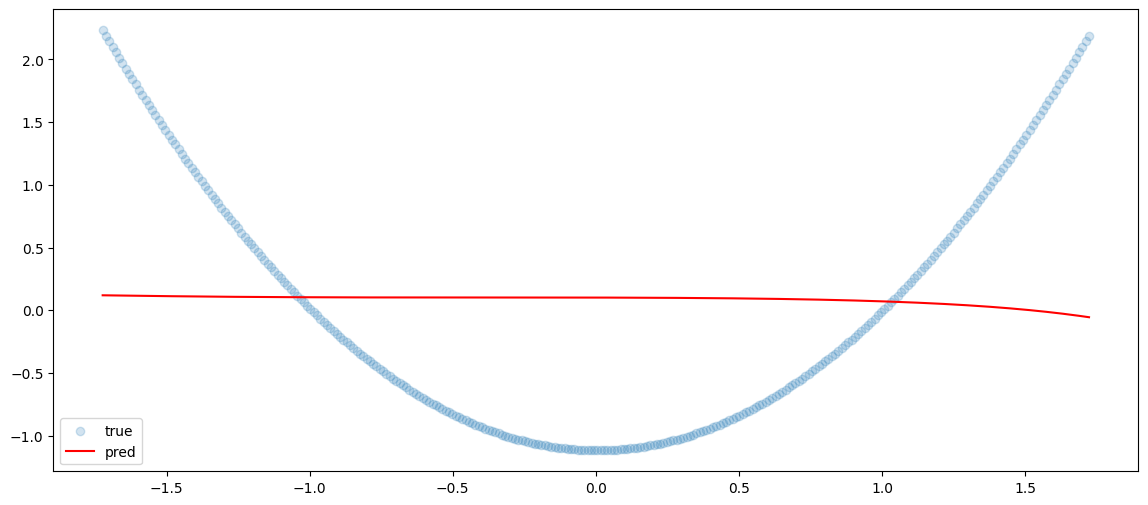

In [87]:
def desc(s, *params, first_n=5):
    print(s, *[param[:first_n].tolist() for param in params])

out = X
desc(f'out init:', out)
for i, (w, b) in enumerate(layers[:-1], start=1):
    print(f'=== layer {i} ===')
    desc(f'params:', w, b)
    out = torch.matmul(out, w) + b
    desc(f'out preact:', out)
    out = (out) ** 3
    desc(f'out postact:', out)

print(f'=== layer final ===')
w_last, b_last = layers[-1]
desc(f'params:', w_last, b_last)
out = torch.matmul(out, w_last) + b_last
desc(f'out final:', out)

with torch.no_grad():
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.scatter(X, y, label='true', alpha=0.2)
    ax.plot(X, out, label='pred', color='red')
    ax.legend()
    plt.show()

In [52]:
def forward(x, layers, activation=torch.relu):
    out = x
    for w, b in layers[:-1]:
        out = torch.matmul(out, w) + b
        out = activation(out)

    w_last, b_last = layers[-1]
    out = torch.matmul(out, w_last) + b_last
    return out


n_epochs = 20
log_interval = n_epochs // 3

lr = 1e-3
n_layers = 2

torch.manual_seed(1)
layers = [(torch.normal(0, 1, size=(1,1), dtype=data_dtype, requires_grad=True),  # w
           torch.normal(0, 1, size=(1,), dtype=data_dtype, requires_grad=True))     # b
          for _ in range(n_layers)]

for epoch in range(n_epochs):
    y_pred = forward(X, layers, )

    loss = criterion(y_pred, y)
    loss.backward()

    with torch.no_grad():
        for w, b in layers:
            w -= lr * w.grad
            b -= lr * b.grad

    for w, b in layers:
        w.grad.zero_()
        b.grad.zero_()

    if epoch % log_interval == 0:
        layers_str = '\n'.join(f'w{i} = {w.item():.3f}, b{i} = {w.item():.3f},'
                               for i, (w, b) in enumerate(layers, start=1))
        print(f'=== epoch {epoch} ===')
        print(layers_str + f'loss = {loss.item():.3f}')

with torch.no_grad():
    y_pred = forward(X, layers)

=== epoch 0 ===
w1 = 0.506, b1 = 0.506,
w2 = -1.613, b2 = -1.613,loss = 53.588
=== epoch 6 ===
w1 = -78.076, b1 = -78.076,
w2 = 23.080, b2 = 23.080,loss = 0.354
=== epoch 12 ===
w1 = -78.076, b1 = -78.076,
w2 = 23.080, b2 = 23.080,loss = 0.348
=== epoch 18 ===
w1 = -78.076, b1 = -78.076,
w2 = 23.080, b2 = 23.080,loss = 0.342


                 --  test loss = 11171249.123893907
                 --  test loss = 11160490.772318805
                 --  test loss = 11150762.995613212
                 --  test loss = 11141885.04730764
                 --  test loss = 11133708.438802263
                 --  test loss = 11126110.337117838
                 --  test loss = 11118987.054675236
                 --  test loss = 11112259.594861405
                 --  test loss = 11105864.810788076
                 --  test loss = 11099754.497070312
                 --  test loss = 11093891.275467936
                 --  test loss = 11088248.53231834
                 --  test loss = 11082807.488859953
                 --  test loss = 11077550.975085448
                 --  test loss = 11072469.137914587
                 --  test loss = 11067550.421557166
                 --  test loss = 11062790.060434299
                 --  test loss = 11058180.611548755
                 --  test loss = 11053717.70713614
               

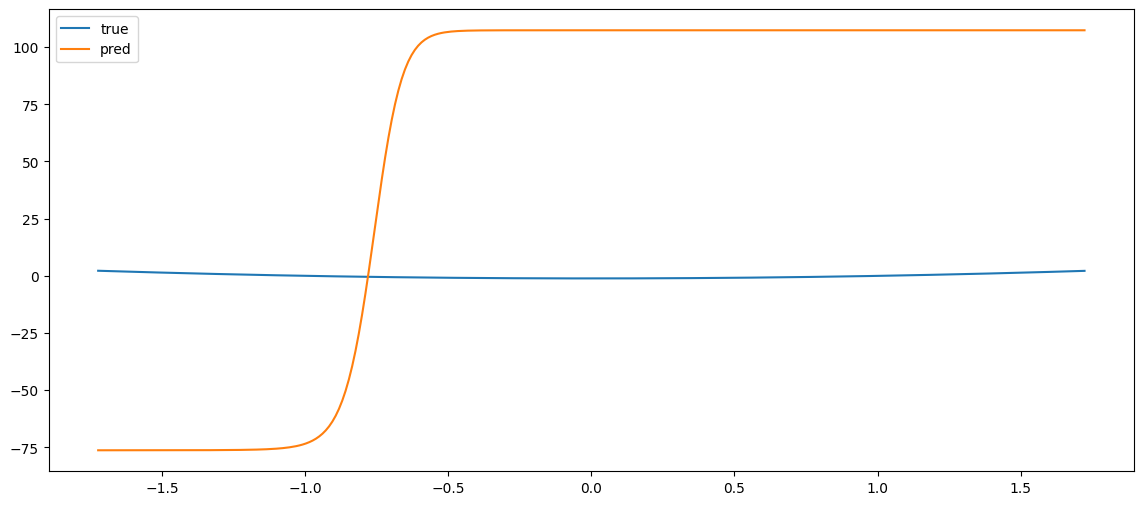

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        output = self.layers(x)
        return output


def train(model, X, y, optimizer, criterion, log_interval):
    model.train()
    for batch_id, (data, target) in enumerate(zip(X, y), start=1):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_id % log_interval == 0:
            print(f'batch {batch_id} -- train loss = {loss.item()}')


def test(model, X, y, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in zip(X, y):
            pred = model(data)
            test_loss += criterion(pred, target).item()

    test_loss /= X.shape[0]
    print(f'                 --  test loss = {test_loss}')


args = {
    "hidden_size": 5,
    "batch_size": 64,
    "test_batch_size": 1000,
    "epochs": 30,
    "lr": 10.0,
    "gamma": 0.7,
    "seed": 1,
    "log_interval": 100,
    "log_interval_test": 30,
}

torch.manual_seed(1)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

X_train, y_train, X_test, y_test = (torch.Tensor(arr).to(device) for arr in [X_train, y_train, X_test, y_test])

model = Net(args["hidden_size"]).to(device)

optimizer = optim.Adadelta(model.parameters(), lr=args["lr"])
criterion = nn.MSELoss()

for epoch in range(args["epochs"]):
    train(model, X_train, y_train, optimizer, criterion, args["log_interval"])
    if epoch % args['log_interval_test']:
        test(model, X_test, y_test, criterion)

with torch.no_grad():
    model.eval()
    y_pred = model(X)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(X, y, label='true')
ax.plot(X, y_pred, label='pred')
ax.legend()
plt.show()

In [91]:
model

Net(
  (fc1): Linear(in_features=1, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

# Backup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output = x
        output = self.fc1(output)
        # output = F.relu(output)
        # output = self.fc2(output)
        return output


def train(model, X, y, optimizer, criterion, log_interval):
    model.train()
    for batch_id, (data, target) in enumerate(zip(X, y), start=1):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_id % log_interval == 0:
            print(f'batch {batch_id} -- train loss = {loss.item()}')


def test(model, X, y, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in zip(X, y):
            pred = model(data)
            test_loss += criterion(pred, target).item()

    test_loss /= X.shape[0]
    print(f'                 --  test loss = {test_loss}')


args = {
    "hidden_size": 5,
    "batch_size": 64,
    "test_batch_size": 1000,
    "epochs": 30,
    "lr": 10.0,
    "gamma": 0.7,
    "seed": 1,
    "log_interval": 100,
    "log_interval_test": 10,
}

torch.manual_seed(1)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

X_train, y_train, X_test, y_test = (torch.Tensor(arr).to(device) for arr in [X_train, y_train, X_test, y_test])

model = Net(args["hidden_size"]).to(device)

optimizer = optim.Adadelta(model.parameters(), lr=args["lr"])
criterion = nn.MSELoss()

for epoch in range(args["epochs"]):
    train(model, X_train, y_train, optimizer, criterion, args["log_interval"])
    if epoch % args['log_interval_test']:
        test(model, X_test, y_test, criterion)


X_tensor, y_tensor = [torch.from_numpy(obj).float().to(device) for obj in [X, y]]

with torch.no_grad():
    model.eval()
    y_pred = model(X_tensor)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(X_tensor, y_tensor, label='true')
ax.plot(X_tensor, y_pred, label='pred')
ax.legend()
plt.show()